<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/3_Introduccion_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales - Convolutional Neural Networks (CNN)

- Las redes neuronales convolucionales se pueden entender como una extensión a las estructuras tipo perceptrón multicapa, buscando dos propiedades cruciales para tareas de visión por computador:

    -- **Invariancia a la traslación**: un objeto puede aparecer en distintos lugares de la imagen. Por ende, se busca que en las primeras capas tipo CNN, la red debe responder de forma similar al mismo parche, sin importar en donde aparece en la imagen.

    -- **Localidad**: las primeras capas deben enfocarse en regiones locales. Se espera que estas pequeñas localidades puedan combinarse para hacer predicciones a nivel de la imagen completa.

- Para ello, las CNN restringen las conexiones de las capas densas a pequeñas regiones, parches, los cuales son operados sobre la imagen de interés.

- A la máscara que contiene los pesos se le conoce tradicionalmente como **filtro o kernel** (*mismo nombre al utilizado en kernel ridge o SVM pero no implica un mapeo no lineal*).



## Repaso operador de convolución

- La convolución entre dos funciones $f,g:\mathbb{R}^d \to \mathbb{R}$, se define como:

$$(f * g)(\mathbf{x})=\int f(\mathbf{z})g(\mathbf{z}-\mathbf{x})d\mathbf{z}$$

en donde el operador de convolución mide el traslape en $f$ y $g$ cuando una de las dos es reflejada y desplazada por $\mathbf{x}$.

- Para el caso de funciones discretas (vectores), la integral se reemplaza por una sumatoria:

$$(f * g)(i)=\sum_{a} f(a)g(i-a)$$

- Para el caso de tensores en dos dimensiones, por ejemplo imágenes en escala de grises, tenemos que:

$$(f * g)(i,j)=\sum_{a} f(a,b)g(i-a,j-b)$$.

- La siguiente animación presenta un ejemplo de la operación de convolución para tensores en 2D en un solo canal (también conocida como *operación de correlación cruzada - cross-correlation*):


![CNN](https://miro.medium.com/max/875/1*32zCSTBi3giSApz1oQV-zA.gif)


- Para el caso de imágenes en color (multicanal), se busca entonces resaltar (aprender) patrones específicos espaciales dependientes de cada canal.

- Por consiguiente, se busca encontrar una representación oculta $\mathbf{H}$ de la entrada $\mathbf{X}$ en múltiples canales, aplicando la convolución de la forma:

$$[\mathbf{H}]_{i,j,d}=\sum_{a=-\Delta}^{\Delta}\sum_{b=-\Delta}^{\Delta}\sum_{c}=[\mathbf{V}]_{a,b,c,d}[\mathbf{X}]_{i+a,j+b,c}$$

donde $a$ y $b$ indexan las traslaciones espaciales, $c$ es la cantidad de canales de la entrada y $d$ la cantidad de canales en la representación oculta, también conocidos como *feature maps*.




## Configuración básica

In [1]:
#importar librerías y configuraciones básicas
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Un par de funciones de utilidad para trazar imágenes en escala de grises y RGB:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Implementación con TensorFlow

En **TensorFlow**, cada imagen de entrada se representa típicamente **como un tensor 3D** de forma [altura, ancho, canales].
- Un mini lote se representa como un tensor de forma 4D [tamaño del mini lote, altura, ancho, canales].
- Los pesos de una capa convolucional se representan como un tensor de forma 4D [$f_h, f_w, f_{n'}, f_n$].
- Los términos de sesgo de una capa convolucional se representan simplemente como un tensor de forma 1D [$f_n$].

**Ejemplo:**
1. Cargamos dos imágenes de muestra, utilizando *load_sample_images()* de Scikit-Learn (que carga dos imágenes en color, una de un templo chino y la otra de una flor).
2. Las intensidades de píxeles (para cada canal de color) se representan como un byte de 0 a 255, por lo que escalamos estas características simplemente dividiendo por 255, para obtener flotantes que van de 0 a 1.
3. Luego creamos dos filtros 7 × 7 (uno con una línea blanca vertical en el medio y la otra con una línea blanca horizontal en el medio), y las aplicamos a ambas imágenes usando la función *tf.nn.conv2d()*.
4. En este ejemplo, usamos zero padding (*padding = "SAME"*) y un stride de 2.
5. Finalmente, trazamos uno de los feature maps resultantes.

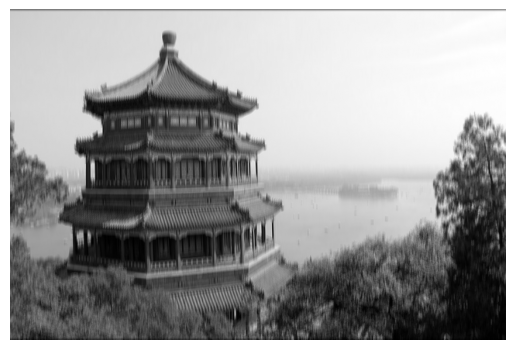

(2, 427, 640, 2)


In [3]:
from sklearn.datasets import load_sample_image

# cargar imágenes
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# crear filtros (kernels) de convolución
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # línea vertical
filters[3, :, :, 1] = 1  # línea horizontal

#aplicamos operación de convolución con tf
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray") # se gráfica el primer filtro
plt.axis("off")
plt.show()
print(outputs.shape) #dos imágenes, ancho, alto, dos filtros

La línea *tf.nn.conv2d()* merece un poco de explicación:

- 'images' es el mini-lote de entrada (un tensor 4D, como se explicó anteriormente).
- 'filters' es el conjunto de filtros a aplicar (también un tensor 4D, como se explicó anteriormente).
- 'strides' es igual a 1, pero también podría ser una matriz 1D con 4 elementos, donde los dos elementos centrales son los pasos verticales y horizontales ($s_h$ y $s_w$). El primer y el último elemento deben ser actualmente iguales a 1.
- El padding debe ser "*VALID*" o "*SAME*":
    - Si se establece en "*VALID*", la capa convolucional no usa relleno de cero y puede ignorar algunas filas y columnas en la parte inferior y derecha de la imagen de entrada, según el paso.
    - Si se establece en "*SAME*", la capa convolucional usa cero relleno si es necesario. En este caso, el número de neuronas de salida es igual al número de neuronas de entrada dividido por el paso, redondeado hacia arriba (en este ejemplo, 13/5 = 2.6, redondeado hasta 3). Luego se agregan ceros de la manera más uniforme posible alrededor de las entradas.



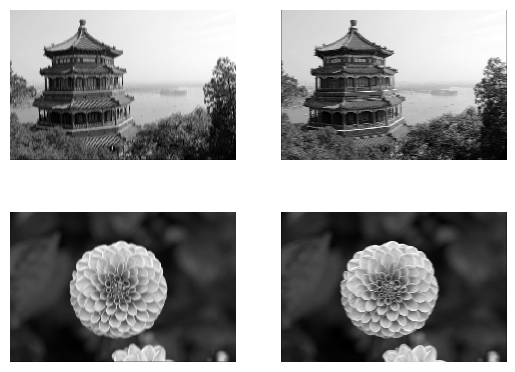

In [4]:
#graficar features maps por cada imagen
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

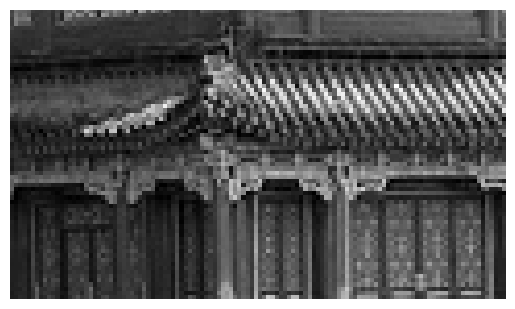

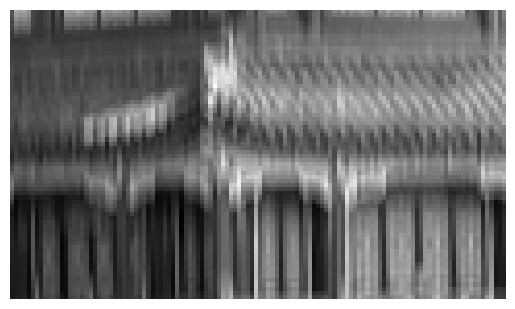

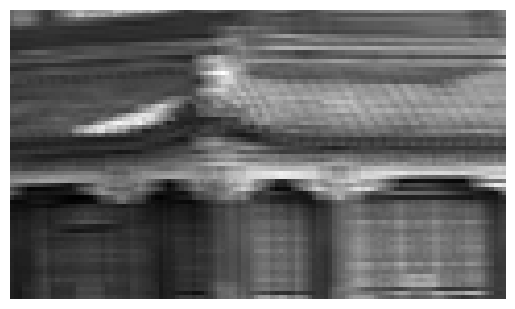

In [6]:
#corte de interés
plot_image(crop(images[0, :, :, 0]))
#save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    #save_fig(filename, tight_layout=False)
    plt.show()

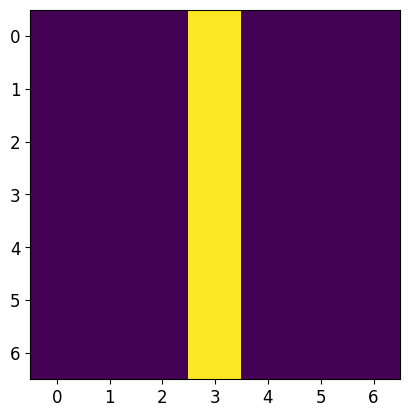

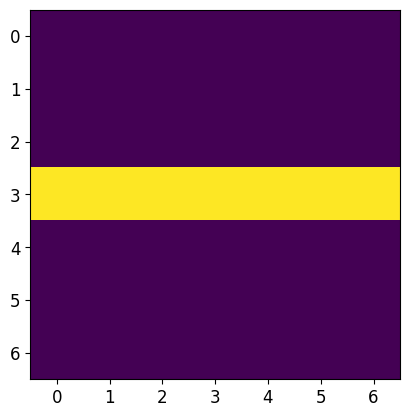

In [7]:
#graficar filtros
plt.imshow(filters[:, :, 0, 0])
plt.show()
plt.imshow(filters[:, :, 0, 1])
plt.show()

## Capa convolucional

- En este ejemplo, **definimos manualmente los filtros**, pero en una CNN real normalmente definiría los **filtros como variables entrenables**, de modo que la red neuronal pueda aprender los filtros que funcionan mejor según la función de costo y base de datos de interés.

- Sin embargo, en lugar de crear manualmente las variables, simplemente puede usar la capa *keras.layers.Conv2D*:

In [8]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

Este código crea una capa Conv2D con 32 filtros, cada uno de $3\times 3$, usando un stride de 1 (tanto horizontal como verticalmente), el padding "SAME", y aplicando la función de activación **ReLU** a sus salidas.

- Como puede ver, las capas convolucionales tienen bastantes hiperparámetros: debe elegir el número de filtros, su altura y ancho, los pasos y el tipo de relleno.

- **Puede usar la validación cruzada para encontrar los valores correctos de hiperparámetro, pero esto lleva mucho tiempo**.

## Capa de pooling

Implementar una capa de **max-pooling** en TensorFlow es bastante fácil.
- El siguiente código crea una capa de max-pooling utilizando un núcleo $2\times 2$.
- Los strides predeterminados para el tamaño del kernel, por lo que esta capa utilizará un stride de 2 (tanto horizontal como verticalmente).
- Por defecto, utiliza padding "VALID" (es decir, sin relleno).

In [9]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [10]:
cropped_images = np.array([crop(image) for image in images])
output         = max_pool(cropped_images)

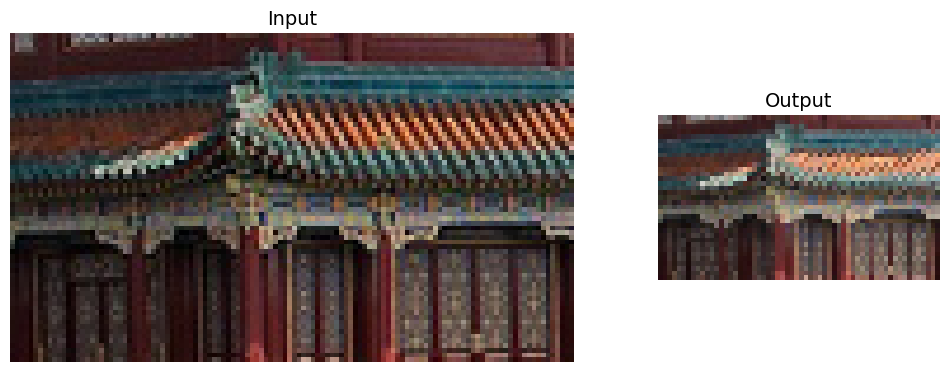

In [11]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
#save_fig("china_max_pooling")
plt.show()

### Average pooling

In [12]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [13]:
output_avg = avg_pool(cropped_images)

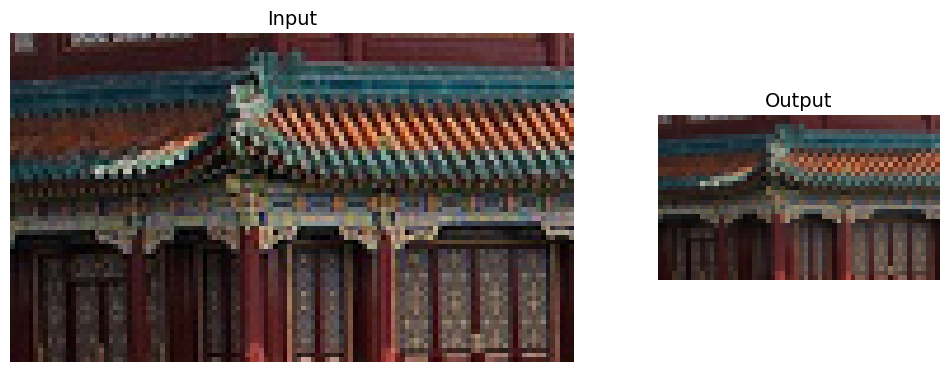

In [14]:
fig = plt.figure(figsize=(12, 8))
gs  = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# CNN para imágenes en múltiples entradas (canales) y múltiples salidas (kernels)

- Es preciso resaltar que cuando se trabaja con varios canales a la entrada, $c>1$, se necesita un filtro (kernel) por cada canal de color.

- Posteriormente, se puede aplicar la operación de convolución y sumar los $c$ resultados para obtener el feature map correspondiente:

![cnnMIMO](https://github.com/amalvarezme/AnaliticaDatos/blob/master/5_Aprendizaje_Profundo/cnnMIMO.png?raw=1)

**Nota**:

- Algunas extensiones de las CNN, incluyen las 1D CNN para trabajar series temporales, las 3D CNN para trabajar sobre volumenes o las dilated o Altrous CNN para realizar upsampling (ver [extensiones CNN Kaggle](https://www.kaggle.com/shivamb/3d-convolutions-understanding-use-case)).

- Además, se puede trabajar con CNN 1 x 1 para encontrar relaciones sobre los canales de color sin considerar las dependencias espaciales (Ver [1 x 1 CNN](https://d2l.ai/chapter_convolutional-neural-networks/channels.html#fig-conv-1x1))

## Construcción de arquitecturas CNN con TensorFlow y Keras

Así es como puede implementar una CNN simple para abordar el conjunto de datos Fashion MNIST:

In [15]:
#cargar datos fashion mnist y partir en train y test
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000]/255., X_train_full[-5000:]/255.
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#recuerde generar la estructura 4D para el entrenamiento
#se genera una nueva dimensión al final porque se trabaja con imágenes en escala de grises
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
from functools import partial

#arquitectura CNN - se crea una capa por defecto por facilidad de cálculo
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([

    #extraer caracteristicas
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    #filtros CNN intermedios
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),

    #clasificador por MLP  -> densas
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5), # regularizar, apagar aleatoriamente neuronas
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Nota**:

- Generalmente en arquitecturas CNN la cantidad de filtros va aumentando a medida que ingresamos en la profundidad de la red.

- Se busca realizar muchas combinaciones con patrones simples de las primeras capas.

- Además, casi siempre se finaliza con un perceptrón multicapa que aprovecha las características aprendidas por las capas CNN.

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

- En este código, comenzamos usando la función *parcial()* para definir la clase **Conv2D**, llamada *DefaultConv2D*: **simplemente evita tener que repetir los mismos valores de hiperparámetro una y otra vez**.

- La primera capa usa un tamaño de kernel grande, pero sin strides porque las imágenes de entrada no son muy grandes. También establece input_shape = [28, 28, 1], lo que significa que las imágenes son $28\times 28$ píxeles, con un solo canal de color (es decir, **escala de grises**).

- A continuación, tenemos una capa de *max-pooling*, que divide cada dimensión espacial por un factor de dos (ya que *pool_size = 2*).

- Luego repetimos la misma estructura dos veces: dos capas convolucionales seguidas de una capa de agrupación máxima.

- Tenga en cuenta que la cantidad de filtros aumenta a medida que subimos la CNN hacia la capa de salida (inicialmente es 64, luego 128, luego 256): tiene sentido que crezca, ya que la cantidad de características de bajo nivel a menudo es bastante bajo (p. ej., círculos pequeños, líneas horizontales, etc.), pero hay muchas formas diferentes de combinarlos en funciones de nivel superior.

- Luego está la red totalmente conectada (Fully-connected), compuesta de 2 capas densas ocultas y una capa de salida densa. Tenga en cuenta que **debemos aplanar sus entradas**, ya que una red densa espera una matriz 1D de características para cada instancia. También agregamos dos capas de *dropout*, con una tasa de dropout del $50\%$ cada una, para reducir el sobreajuste.

In [18]:
#se compila y ajusta el modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.6267 - loss: 1.0264 - val_accuracy: 0.8770 - val_loss: 0.3437
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8526 - loss: 0.4406 - val_accuracy: 0.8886 - val_loss: 0.2989
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8739 - loss: 0.3648 - val_accuracy: 0.8940 - val_loss: 0.2942
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8859 - loss: 0.3241 - val_accuracy: 0.8968 - val_loss: 0.2950
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8984 - loss: 0.2982 - val_accuracy: 0.8936 - val_loss: 0.2845
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9022 - loss: 0.2744 - val_accuracy: 0.8970 - val_loss: 0.2783
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9121 - loss: 0.2544 - val_accuracy: 0.8986 - val_loss: 0.2915
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9152 - loss: 

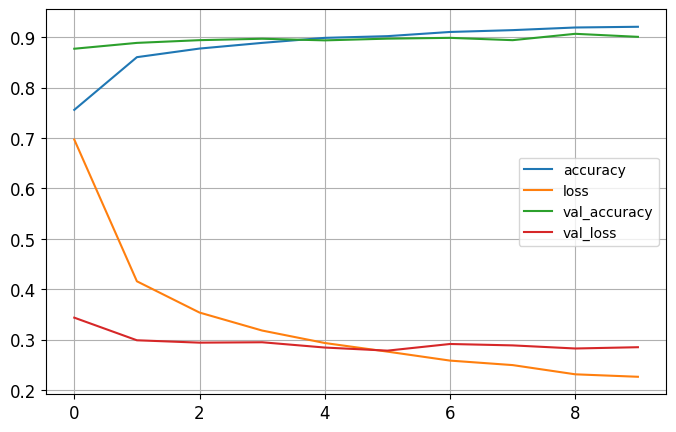

In [19]:
import pandas as pd
#se grafica el historial del gradiente
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [20]:
#evalumos el desempeño de la red
score   = model.evaluate(X_test, y_test)
print(score)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8584 - loss: 39.0163
[38.47300338745117, 0.8578000068664551]


In [21]:
#se predicen dos imágenes de ejemplo
X_new   = X_test[:2]
y_pred  = np.argmax(model.predict(X_new),axis=1)
print(y_pred,y_test[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
[9 2] [9 2]


# Mapas de características - feature maps

- Podemos interpretar los patrones extraídos por los kernels aprendidos en el entrenamiento (recuerde que la red fijo los pesos), graficando los feature maps.

In [22]:
def plot_featureMaps(X,model,layer_name,n_rows=4,n_cols=4):
    model_B = tf.keras.Model(inputs=model.inputs,outputs=model.get_layer(layer_name).output) #se accede a capas por nombre
    #tf.keras.utils.plot_model(model_B) # modleo ya esta ajustado!
    z = model_B.predict(X)
    print('Shape',z.shape)
    plt.figure(figsize=(3,3))
    if X.shape[-1]==1:
        plt.imshow(X[0,:,:,0], cmap="binary", interpolation="nearest")
    else:
        plt.imshow(X[0])
    tit=str(model.predict(X).round(2))
    plt.title(tit)
    plt.axis('off')
    plt.show()

    f, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(6,6))
    index = 0
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            pb = ax[row,col].imshow(z[0,:,:,index], cmap="jet", interpolation="nearest",vmin=z.min(),vmax=z.max())
            ax[row,col].axis('off')
            ax[row,col].set_title("f_m" + str(index+1), fontsize=12)

    plt.tight_layout()
    cbar_ax = f.add_axes([1.01, 0, 0.025, 0.95])
    f.colorbar(pb,shrink=0.25, cax=cbar_ax)
    #save_fig('fashion_mnist_plot', tight_layout=False)
    plt.show()
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


Shape (1, 28, 28, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


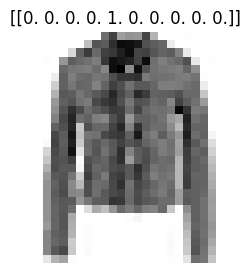

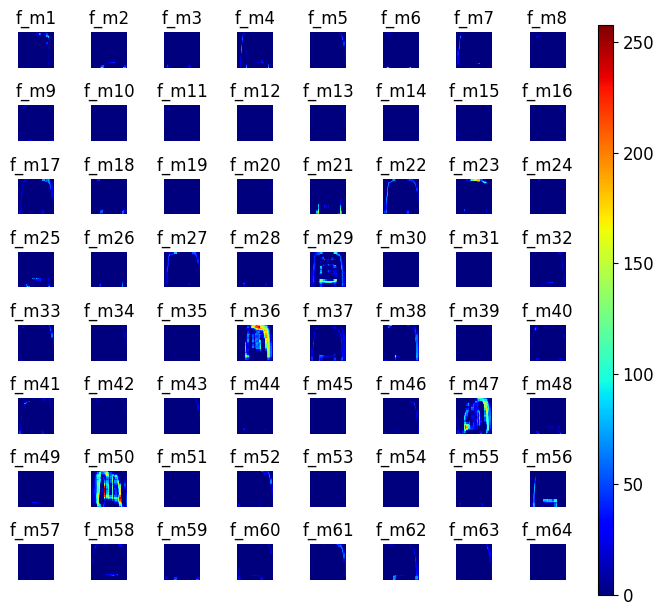

In [23]:
plot_featureMaps(X_test[10][np.newaxis,...],model,layer_name=model.layers[0].name,n_rows=8,n_cols=8)

También podemos graficar los  pesos de la máscara de convolución, recuerde que dichos pesos se dejan fijos despues de entrenamiento, y generalmente las dimensiones son más pequeñas que las de las imagenes originales.


In [24]:
print(model.layers[0].get_weights()[0].shape) #filtros de la primera capa CNN
print(model.layers[0].get_weights()[1].shape) #bias de la primera capa CNN

(7, 7, 1, 64)
(64,)


In [25]:
def plot_filters(model,layer_name,n_rows=4,n_cols=4):
    print('Filtros capa '+layer_name)
    print(model.get_layer(layer_name).get_weights()[0].shape)
    z = model.get_layer(layer_name).get_weights()[0]
    f, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(6,6))
    index = 0
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            pb = ax[row,col].imshow(z[:,:,0,index], cmap="jet", interpolation="nearest",vmin=z.min(),vmax=z.max())
            ax[row,col].axis('off')
            ax[row,col].set_title("f" + str(index+1), fontsize=12)

    plt.tight_layout()
    cbar_ax = f.add_axes([1.01, 0, 0.025, 0.95])
    f.colorbar(pb,shrink=0.25, cax=cbar_ax)
    #save_fig('fashion_mnist_plot', tight_layout=False)
    plt.show()
    return

Filtros capa conv2d_1
(7, 7, 1, 64)


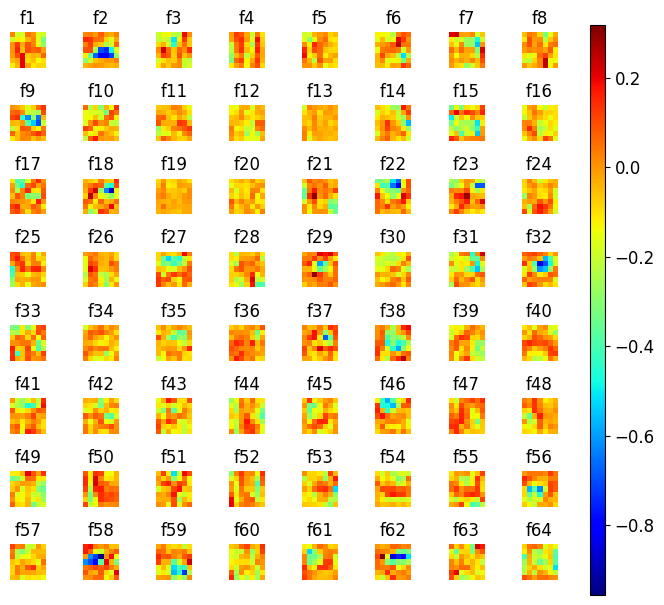

In [26]:
plot_filters(model,layer_name=model.layers[0].name,n_rows=8,n_cols=8)

- Algunas otras aproximaciones para la visualización de los patrones aprendidos por la CNN, incluyen mapas de activación restringidos a la clase (class activation maps) y optimizaciones para la construcción de imágenes de entrada que maximización la activación de un filtro dado. Para más detalle ver [keras-vis](https://keisen.github.io/tf-keras-vis-docs/) y [Cuaderno ejemplo CAMs Mnist](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/6_Mnist_CAMs.ipynb)

# Tareas y modelos recientes de visión ppr computador

https://viso.ai/deep-learning/computer-vision-tasks/
